In [39]:
import itertools
import pickle
import warnings
warnings.filterwarnings("ignore")

import deepdish as dd
import hpacellseg.cellsegmentator as cellsegmentor
from hpacellseg.utils import label_cell, label_nuclei
import matplotlib.pyplot as plt
import numpy as np
np.bool = bool
from torch import nn
from tqdm import trange

In [31]:
with open("../one_sample.pkl", "rb") as in_file:
    ref_img = pickle.load(in_file)
# ref_img = sample["ref-image"]
print(ref_img)

[[[  6  36 255]
  [  2  29 255]
  [  2  41 255]
  ...
  [  0   1   0]
  [  0   1   0]
  [  0   3   0]]

 [[  4  15 255]
  [  5  22 255]
  [  3  17 255]
  ...
  [  3   6   0]
  [  0   1   0]
  [  0   3   0]]

 [[  8  22 255]
  [  4  28 255]
  [  3  13 255]
  ...
  [  0   2   0]
  [  0   2   0]
  [  3   1   0]]

 ...

 [[ 79  79   0]
  [ 60  92   1]
  [100 212   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 42  85   0]
  [ 48 119   1]
  [ 84 194   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 21  71   0]
  [ 37 106   0]
  [ 74 112   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


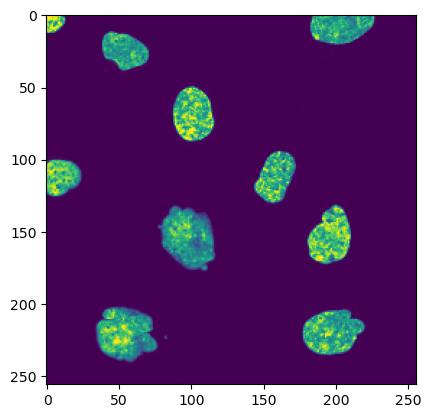

In [34]:
fig, ax = plt.subplots()
ax.imshow(ref_img[:, :, 2])
# axes[0, 0].set_title(f"Ref image before rotation")

In [40]:
segmentor = cellsegmentor.CellSegmentator(
    # recommended 0.25; our samples are already downsized by 0.125
    scale_factor=2,
    # NOTE: setting padding=True seems to solve most issues that have been encountered
    #       during our single cell Kaggle challenge.
    device="cpu",
    padding=True,
    multi_channel_model=True
)

# To fix a pytorch 1.11.0 compatibility issue using the solution from https://github.com/ultralytics/yolov5/issues/6948#issuecomment-1299936326
for m in itertools.chain(segmentor.nuclei_model.modules(), segmentor.cell_model.modules()):
    if isinstance(m, nn.Upsample):
        m.recompute_scale_factor = None
bulk_imgs = [ref_img]
nuc_segmentations = segmentor.pred_nuclei(bulk_imgs)
cell_segmentations = segmentor.pred_cells(bulk_imgs, precombined=True)
masks = [label_cell(nuc, cell) for nuc, cell in zip(nuc_segmentations, cell_segmentations)]
masks

[(array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint16))]

In [41]:
masks[0][0].sum()

0

In [47]:
nuc_segmentations[0][:, :, 2]

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

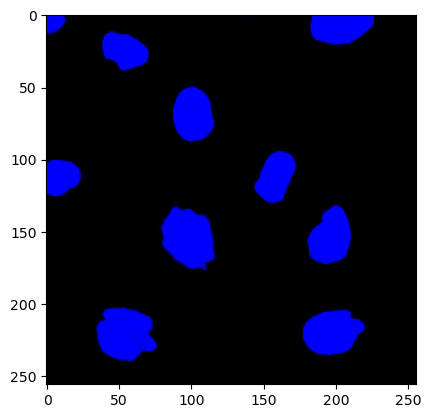

In [56]:
fig, ax = plt.subplots()
ax.imshow(nuc_segmentations[0][:, :])

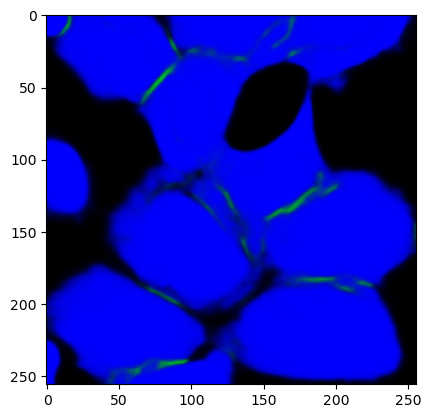

In [55]:
fig, ax = plt.subplots()
ax.imshow(cell_segmentations[0][:, :])

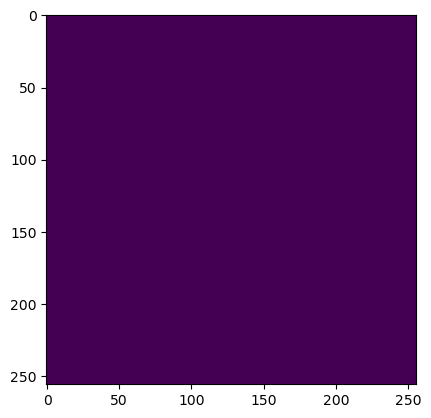

In [58]:
mask = label_cell(nuc_segmentations[0], cell_segmentations[0])

fig, ax = plt.subplots()
ax.imshow(mask[1])

In [53]:
ax.imshow(mask[1])